## 📦 Setup

In [36]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from dotenv import load_dotenv
from matplotlib.ticker import ScalarFormatter

# Add project root to path
sys.path.insert(0, os.path.abspath('..'))

from nlp.embeddings import EmbeddingGenerator

load_dotenv()

# Configuration
PROJECT_ID = os.getenv('GCP_PROJECT_ID', 'sg-job-market')
DATASET_ID = os.getenv('BQ_DATASET_ID', 'sg_job_market')

print("✅ Imports successful")
print(f"Project: {PROJECT_ID}")
print(f"Dataset: {DATASET_ID}")

✅ Imports successful
Project: sg-job-market
Dataset: sg_job_market


In [37]:
client = bigquery.Client(project=PROJECT_ID)

query = f"""
SELECT 
    e.job_id,
    e.source,
    e.embedding,
    e.model_name,
    e.created_at,
    c.job_title,
    c.company_name,
    c.job_location,
    c.job_classification
FROM `{PROJECT_ID}.{DATASET_ID}.job_embeddings` e
JOIN (
    SELECT 
        job_id,
        source,
        job_title,
        company_name,
        job_location,
        job_classification,
        ROW_NUMBER() OVER (
            PARTITION BY source, job_id 
            ORDER BY scrape_timestamp DESC
        ) AS rn
    FROM `{PROJECT_ID}.{DATASET_ID}.cleaned_jobs`
) c
ON e.job_id = c.job_id AND e.source = c.source
WHERE c.rn = 1
LIMIT 10000
"""

print("Loading embeddings from BigQuery...")
df = client.query(query).to_dataframe()

print(f"\n✅ Loaded {len(df):,} jobs with embeddings")
print(f"Embedding dimension: {len(df['embedding'].iloc[0])}")
print(f"\nSample data:")
df[['job_title', 'company_name', 'job_classification']].head()

Loading embeddings from BigQuery...


c:\Users\User\Documents\SG_Job_Market\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



✅ Loaded 6,785 jobs with embeddings
Embedding dimension: 384

Sample data:


,job_title,company_name,job_classification
0,Event and Marketing (Entry Level),MYTHIC VISION,Marketing / Public Relations
1,SOFTWARE DEVELOPER,UARROW .,Banking and Finance
2,Production Store Supervisor,LIAN HIN .,Customer Service
3,Assistant Banquet Manager,SENTOSA BEACH RESORT,F&B
4,SITE ENGINEER,DONG JIAN ENGINEERING .,Building and Construction


## 🔍 Test Similarity Search

Find jobs similar to a query using cosine similarity.

In [38]:
# Generate embedding for query
generator = EmbeddingGenerator()
query_text = "Senior Data Scientist with Python and machine learning experience"

print(f"Query: {query_text}")
print("\nGenerating query embedding...")
query_embedding = generator.embed_texts([query_text])

print(f"> Embedded matrix: {query_embedding}")
print(f"\n> Query embedding shape: {query_embedding.shape}")

# Since we only have one query, we take the first row
query_embedding = query_embedding[0]
print(f"\n> Query embedding vector shape: {query_embedding.shape}")

Query: Senior Data Scientist with Python and machine learning experience

Generating query embedding...


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.03it/s]

> Embedded matrix: [[-8.14497843e-02  2.61427164e-02  6.16718084e-02  6.67643771e-02
  -7.61197461e-03 -1.44538581e-01 -4.00911644e-02 -3.23459655e-02
  -1.56884685e-01 -4.77438755e-02 -7.87186027e-02 -2.34097075e-02
   4.63907644e-02 -1.95023045e-02  3.21459547e-02  1.08191848e-01
  -1.01614125e-01 -2.46658474e-02  4.78268042e-03 -1.20968275e-01
  -4.70162444e-02 -7.23217847e-03 -1.41038913e-02 -4.45014313e-02
   6.55130595e-02 -3.91232856e-02  3.53042148e-02  6.23796768e-02
  -2.10496597e-02  3.39972600e-02 -2.86967829e-02 -2.79243384e-02
  -1.50212394e-02  5.38915880e-02  1.80311850e-03  4.46798392e-02
   3.91765647e-02 -1.21125979e-02 -1.43404044e-02  5.75038269e-02
  -1.42612681e-02  4.15800698e-03 -2.92154448e-03 -3.96813937e-02
  -1.01660015e-02 -5.27241128e-03  1.32119376e-02 -1.17309138e-01
   4.90341075e-02 -3.39578018e-02 -2.83774007e-02 -3.30944881e-02
  -4.23823996e-03 -9.11882073e-02 -4.46428433e-02 -1.81986819e-04
   7.47091696e-02 -3.39747220e-03  3.03726504e-03 -1.1072

In [39]:
print("> Original embeddings from df (taking only the first 2 elements):")
print(df['embedding'].values[:2])
print(f"\n> Number of embeddings: {len(df['embedding'].values)}")

# We do a vertical stack to convert list of arrays into 2D array
embeddings_matrix = np.vstack(df['embedding'].values)

print ("\n> Embedded matrix from df:")
print(embeddings_matrix)
print(f"\n> Embeddings matrix shape: {embeddings_matrix.shape}")

> Original embeddings from df (taking only the first 2 elements):
[array([ 2.87929662e-02, -8.08602795e-02,  1.93207785e-02,  6.02977984e-02,
         5.45769222e-02,  2.71645803e-02,  5.35891838e-02, -3.41009125e-02,
        -4.28703427e-02, -7.95591474e-02,  4.13474403e-02, -1.82973575e-02,
        -1.69554483e-02,  2.57354742e-03,  1.93062555e-02, -3.28256078e-02,
         5.68125211e-03,  1.19287930e-02,  5.32607287e-02, -7.11046830e-02,
        -7.42864311e-02, -9.46716443e-02, -7.67718023e-03,  5.01825698e-02,
        -6.42520413e-02, -3.97871435e-02, -1.37124313e-02,  3.54624689e-02,
        -4.96530626e-03, -8.78563151e-02, -3.44726890e-02,  5.41233793e-02,
         2.49386951e-02,  2.92178839e-02,  1.13208748e-01,  1.00860849e-01,
        -1.07613788e-03, -5.88129200e-02,  1.01373777e-01,  6.00900315e-02,
         1.79441236e-02, -6.85970634e-02, -6.03689402e-02, -3.45101655e-02,
         3.10054608e-02, -1.11062437e-01,  4.70791049e-02,  8.93485919e-02,
        -5.97357377e-0

In [ ]:
# Calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity([query_embedding], embeddings_matrix)

print(f"> Similarities: {similarities}")
print(f"> Similarities shape: {similarities.shape}")

# Since we have only one query, take the first row
similarities = similarities[0]
print(f"\n> Similarity scores vector shape: {similarities.shape}")

# Add similarity scores to dataframe
df['similarity'] = similarities

# See similarity column
df[['job_title', 'company_name', 'similarity']].head()

# Get top 10 similar jobs
# Note: Similarity is based on embeddings generated from job_title + job_description,
# but we show other fields (company, classification, location) for context
top_jobs_all = df.nlargest(10, 'similarity')

top_jobs = top_jobs_all[['job_title', 'company_name', 'job_classification', 'job_location', 'similarity']]

print(f"\n🎯 Top 10 Similar Jobs:\n")
print(f"{'Score':<6}| {'Job Title':<50} | {'Company':<30} | {'Location':<30} | {'Category':<30}")
print("-" * 150)
for idx, row in top_jobs.iterrows():
    print(f"{row['similarity']:.3f} | {row['job_title'][:50]:50} | {row['company_name'][:30]:30} | {row['job_location'][:30]:30} | {row['job_classification'][:30]:30}")

> Similarities: [[0.24366621 0.33283534 0.17798232 ... 0.30586248 0.25201221 0.19597864]]

> Similarities shape: (1, 6785)

> Similarity scores vector shape: (6785,)

🎯 Top 10 Similar Jobs:

Score | Job Title                                          | Company                        | Location                       | Category                      
------------------------------------------------------------------------------------------------------------------------------------------------------
0.625 | Python Developer                                   | OPTIMUM SOLUTIONS (SINGAPORE)  | Islandwide                     | Information Technology        
0.584 | Senior Data Scientist                              | Maybank                        | Central                        | Science & Technology - Mathema
0.554 | (Senior) Data Scientist (AI)                       | RANDSTAD PTE.                  | D01 Cecil, Marina, People’S Pa | Information Technology        
0.547 | Senior Gen AI Deve

## 🔍 Verify Dataset Composition

Check if the sample actually contains Data Scientist jobs.

In [41]:
# Check if our sample contains actual Data Scientist jobs
print("🔍 Checking for Data Scientist jobs in sample...\n")

# Search for jobs with "Data Scientist" in title
data_scientist_jobs = df[df['job_title'].str.contains('Data Scientist', case=False, na=False)]
print(f"Jobs with 'Data Scientist' in title: {len(data_scientist_jobs)}")

if len(data_scientist_jobs) > 0:
    print("\n📋 Data Scientist jobs found:")
    print(data_scientist_jobs[['job_title', 'company_name', 'job_classification']].to_string(index=False))
    
    # Calculate similarity between query and actual Data Scientist jobs
    if len(data_scientist_jobs) > 0:
        ds_indices = data_scientist_jobs.index
        ds_similarities = df.loc[ds_indices, 'similarity'].values
        print(f"\n📊 Similarity scores for Data Scientist jobs:")
        print(f"  Mean: {ds_similarities.mean():.3f}")
        print(f"  Max: {ds_similarities.max():.3f}")
        print(f"  Min: {ds_similarities.min():.3f}")
else:
    print("⚠️ No 'Data Scientist' jobs in this sample of 1000!")
    print("   This explains why similarity scores are low.")
    
# Search for related ML/AI jobs
ml_jobs = df[df['job_title'].str.contains('Machine Learning|ML Engineer|AI Engineer|Data Science', case=False, na=False)]
print(f"\n🤖 Jobs with ML/AI keywords in title: {len(ml_jobs)}")

if len(ml_jobs) > 0:
    print("\n📋 Sample ML/AI jobs:")
    print(ml_jobs[['job_title', 'company_name', 'similarity']].head(10).to_string(index=False))

🔍 Checking for Data Scientist jobs in sample...

Jobs with 'Data Scientist' in title: 8

📋 Data Scientist jobs found:
                   job_title                         company_name                                                    job_classification
       Senior Data Scientist               DIGITAL PLACE VISION . Science & Technology - Mathematics, Statistics & Information Sciences
     Data Scientist, Manager                     OCBC (singapore)    Information & Communication Technology - Business/Systems Analysts
      Data Scientist, AI Lab                     OCBC (singapore)       Information & Communication Technology - Engineering - Software
              Data Scientist                            TRULYYY . Science & Technology - Mathematics, Statistics & Information Sciences
       Senior Data Scientist                              Maybank Science & Technology - Mathematics, Statistics & Information Sciences
              Data Scientist                                 TDCX 

## 🎯 Test with Better Query

Let's try a query that matches jobs actually in the dataset.

In [42]:
# Pick a common job title from the dataset (after lowercasing) and test similarity
common_titles = df['job_title'].str.lower().value_counts().head(10)
print("📊 Top 10 most common job titles in sample:")
print(common_titles)

# Test with a title that exists in dataset
test_query = "answer any query from client efficiently through tickets and calls"
print(f"\n🔍 Testing with: '{test_query}'")

test_embedding = generator.embed_texts([test_query])[0]
test_similarities = cosine_similarity([test_embedding], embeddings_matrix)[0]
df['test_similarity'] = test_similarities

test_top_jobs = df.nlargest(10, 'test_similarity')[['job_title', 'company_name', 'test_similarity']]

print(f"\n🎯 Top 10 Similar Jobs:\n")
for idx, row in test_top_jobs.iterrows():
    print(f"{row['test_similarity']:.3f} | {row['job_title'][:60]:60} | {row['company_name'][:30]:30}")

📊 Top 10 most common job titles in sample:
job_title
supervisor                      61
quantity surveyor               38
beautician                      32
assistant cook                  26
chef                            25
project engineer                21
project manager                 20
project coordinator             17
sales executive                 17
business development manager    17
Name: count, dtype: int64

🔍 Testing with: 'answer any query from client efficiently through tickets and calls'


Batches: 100%|██████████| 1/1 [00:00<00:00, 195.05it/s]


🎯 Top 10 Similar Jobs:

0.344 | Ticketing & Reservation Executive                            | ALKANAAH INTERNATIONAL TOURS &
0.318 | Customer Service Support                                     | ICHOR SYSTEMS SINGAPORE .     
0.308 | AI (Python/TypeScript/Go/Java) @ Central | Up to $13,800 | R | Recruitfirst                  
0.302 | Customer Service Support                                     | Ichor Systems Singapore .     
0.291 | Front Desk Receptionist (Resort)                             | SENTOSA BEACH RESORT          
0.291 | Front Desk Receptionist (Resort)                             | Shangri-la Singapore          
0.289 | FX CLIENT SERVICE SPECIALIST (Rotating Shift: 2pm-11pm/10:30 | SPARK SYSTEMS .               
0.287 | Sales Admin (East / Vlookup) - SS10                          | THE SUPREME HR ADVISORY .     
0.283 | Network Support (Rotating Shift)| West                       | GMP TECHNOLOGIES (S)          
0.283 | Reservations & Call Centre Executive             

## 📈 Embedding Quality Checks

📊 Embedding Statistics:

Shape: (6785, 384)
Value range: [-0.232, 0.244]
Mean: -0.001
Std: 0.051

📏 Vector Norms: 1.000 (Means)
Std: 0.000
Min: 1.000
Max: 1.000

✅ Embeddings are properly normalized (unit vectors)


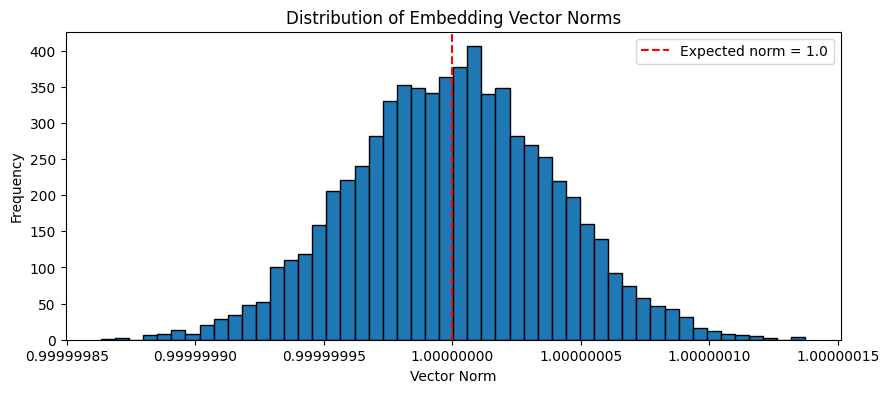

In [43]:
# Check embedding statistics
embeddings_matrix = np.vstack(df['embedding'].values)

print("📊 Embedding Statistics:\n")
print(f"Shape: {embeddings_matrix.shape}")
print(f"Value range: [{embeddings_matrix.min():.3f}, {embeddings_matrix.max():.3f}]")
print(f"Mean: {embeddings_matrix.mean():.3f}")
print(f"Std: {embeddings_matrix.std():.3f}")

# Check normalization (SBERT embeddings should have norm ≈ 1)
norms = np.linalg.norm(embeddings_matrix, axis=1)
print(f"\n📏 Vector Norms: {norms.mean():.3f} (Means)")
# print(f"Mean: {norms.mean():.3f}")
print(f"Std: {norms.std():.3f}")
print(f"Min: {norms.min():.3f}")
print(f"Max: {norms.max():.3f}")

if abs(norms.mean() - 1.0) < 0.01:
    print("\n✅ Embeddings are properly normalized (unit vectors)")
else:
    print("\n⚠️ Warning: Embeddings may not be normalized")

# Plot norm distribution
plt.figure(figsize=(10, 4))
plt.hist(norms, bins=50, edgecolor='black')
plt.axvline(1.0, color='red', linestyle='--', label='Expected norm = 1.0')

# Get the current axis and apply the formatter
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.xlabel('Vector Norm')
plt.ylabel('Frequency')
plt.title('Distribution of Embedding Vector Norms')
plt.legend()
plt.show()

## 🔬 Understanding L2 Norm vs Embedding Values

Let's visualize the difference between embedding values and their norms.

📊 One Embedding Vector:

First 10 values: [ 0.02879297 -0.08086028  0.01932078  0.0602978   0.05457692  0.02716458
  0.05358918 -0.03410091 -0.04287034 -0.07955915]

📏 Individual Values:
  Min: -0.166  ← Can be negative!
  Max: 0.157  ← Can be positive!
  Range: [-0.166, 0.157]

🔢 L2 Norm Calculation:
  Sum of 384 squared values: 1.000
  L2 norm = √1.000 = 1.000

✅ L2 norm is always POSITIVE (it's a length!)


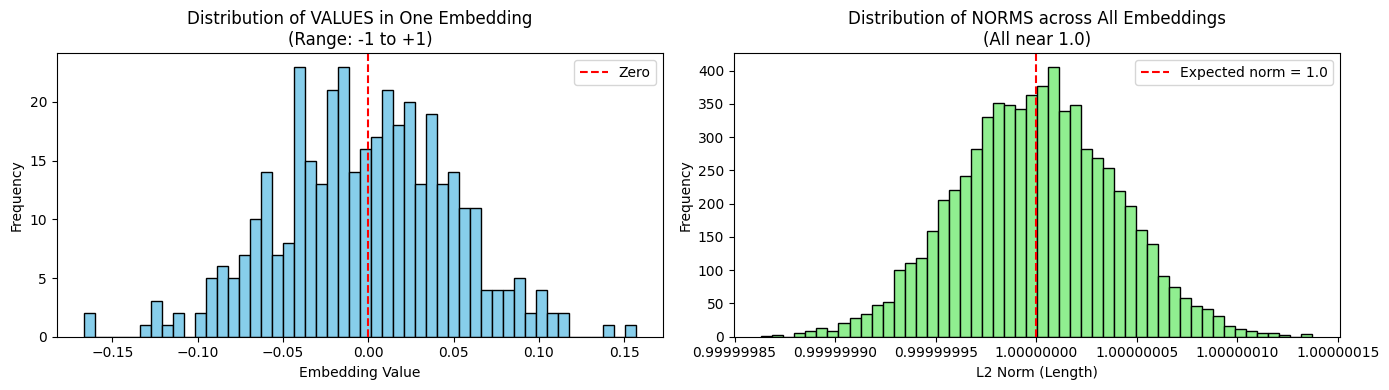


KEY DIFFERENCE:
  Left: Individual embedding VALUES (can be -1 to +1)
  Right: L2 NORMS of embeddings (always positive, near 1.0)


In [ ]:
# Take one embedding to demonstrate
sample_embedding = embeddings_matrix[0]  # 384 values

print("📊 One Embedding Vector:\n")
print(f"First 10 values: {sample_embedding[:10]}")
print(f"\n📏 Individual Values:")
print(f"  Min: {sample_embedding.min():.3f}  ← Can be negative!")
print(f"  Max: {sample_embedding.max():.3f}  ← Can be positive!")
print(f"  Range: [{sample_embedding.min():.3f}, {sample_embedding.max():.3f}]")

# Calculate L2 norm manually
squared_values = sample_embedding ** 2  # Square each value
sum_of_squares = squared_values.sum()   # Add them all
l2_norm = np.sqrt(sum_of_squares)       # Take square root

print(f"\n🔢 L2 Norm Calculation:")
print(f"  Sum of 384 squared values: {sum_of_squares:.3f}")
print(f"  L2 norm = √{sum_of_squares:.3f} = {l2_norm:.3f}")
print(f"\n✅ L2 norm is always POSITIVE (it's a length!)")

# Visualize both
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left plot: Individual embedding values
axes[0].hist(sample_embedding, bins=50, edgecolor='black', color='skyblue')
axes[0].axvline(0, color='red', linestyle='--', label='Zero')
axes[0].set_xlabel('Embedding Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of VALUES in One Embedding\n(Range: -1 to +1)')
axes[0].legend()

# Right plot: Norms of all embeddings
axes[1].hist(norms, bins=50, edgecolor='black', color='lightgreen')
axes[1].axvline(1.0, color='red', linestyle='--', label='Expected norm = 1.0')
axes[1].xaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # To show exact number
axes[1].set_xlabel('L2 Norm (Length)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of NORMS across All Embeddings\n(All near 1.0)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY DIFFERENCE:")
print("  Left: Individual embedding VALUES (can be -1 to +1)")
print("  Right: L2 NORMS of embeddings (always positive, near 1.0)")
print("="*70)

## 🎨 Visualize Embeddings with PCA

PC1 (23.4% variance) might represent: "Technical vs Non-Technical"  
   x = -5.0  →  Highly technical (Software Engineer, Data Scientist)  
   x =  0.0  →  Neutral (Project Manager, Business Analyst)  
   x = +5.0  →  Non-technical (Sales, HR, Admin)  

PC2 (12.1% variance) might represent: "Seniority vs Entry-Level"  
   y = +4.0  →  Senior roles (Director, Lead, Principal)  
   y =  0.0  →  Mid-level  
   y = -4.0  →  Junior/Entry-level  

Reducing 384 dimensions to 2D with PCA...
✅ Explained variance: 10.83%


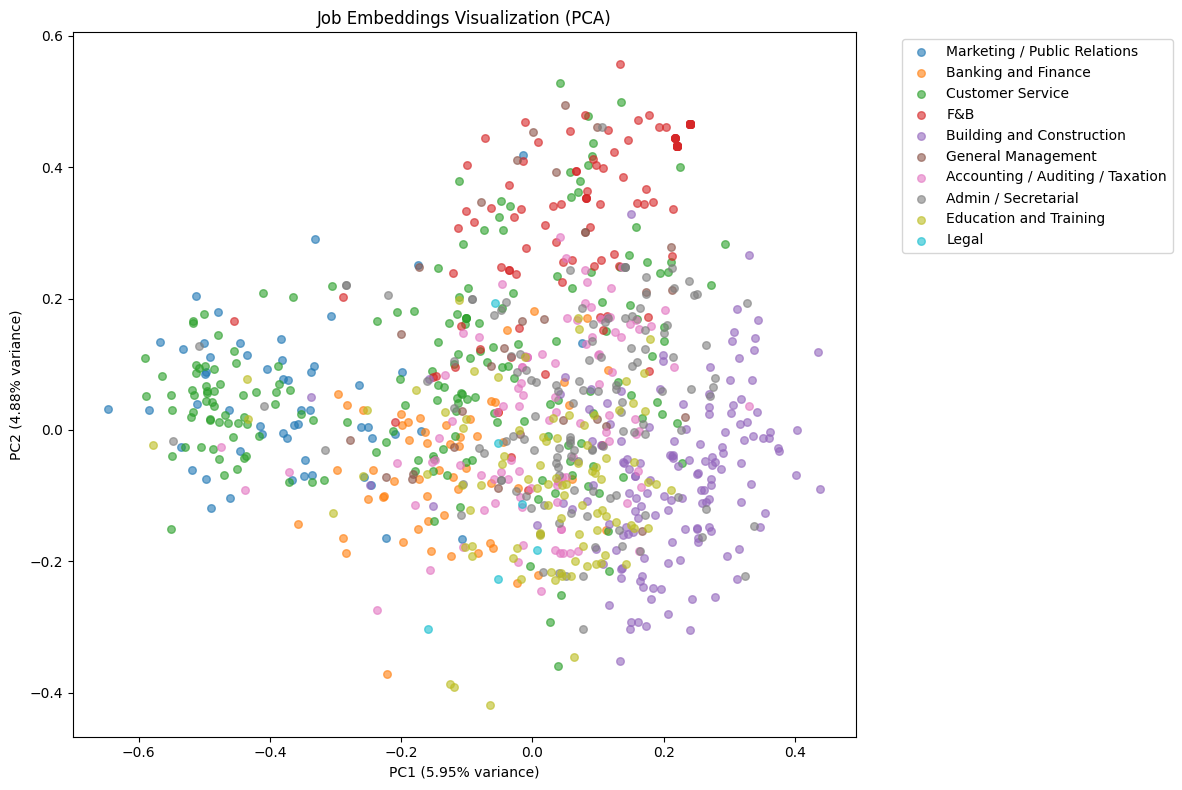

In [48]:
# Reduce to 2D using PCA
print("Reducing 384 dimensions to 2D with PCA...")
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings_matrix)

df['pca_1'] = embeddings_2d[:, 0]
df['pca_2'] = embeddings_2d[:, 1]


print(f"✅ Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Good values:
# >30% total variance in 2D → Good separation
# <20% total variance → Data is very high-dimensional, 2D plot may be misleading

# Plot by job classification
plt.figure(figsize=(12, 8))
for classification in df['job_classification'].dropna().unique()[:10]:
    subset = df[df['job_classification'] == classification]
    plt.scatter(subset['pca_1'], subset['pca_2'], 
                label=classification, alpha=0.6, s=30) # Alpha = transparency level, s = size

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Job Embeddings Visualization (PCA)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # bbox_to_anchor to place legend outside of x, y # loc is allignment
plt.tight_layout()
plt.show()

## 🎯 Analyze Similarity by Category


📊 Intra-Category Similarity (Higher = More Cohesive):

                                                   category  count  avg_similarity
                                                        F&B    138        0.562987
                  Sales - Sales Representatives/Consultants    143        0.461216
                                  Building and Construction    147        0.419921
                       Engineering - Mechanical Engineering    139        0.411692
                           Sales - New Business Development    171        0.408962
Administration & Office Support - Administrative Assistants    239        0.402437
                                     Information Technology    150        0.401939
            Engineering - Electrical/Electronic Engineering    146        0.390161
                                                Engineering    187        0.388542
                                           Customer Service    188        0.362402


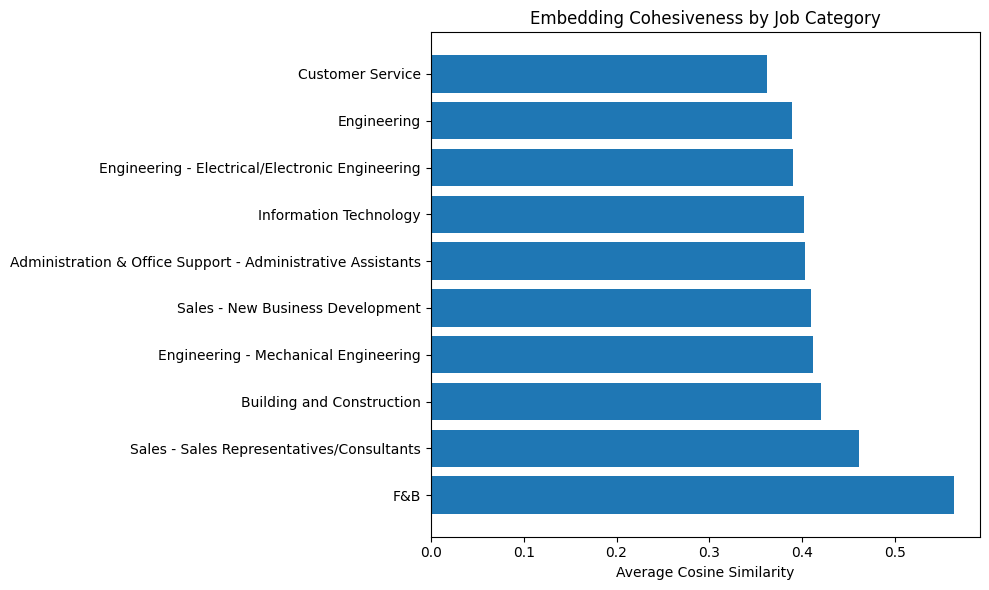

In [46]:
# Group by job classification and check intra-cluster similarity
from sklearn.metrics.pairwise import cosine_similarity

def calculate_intra_cluster_similarity(df, classification):
    """Calculate average similarity within a job classification."""
    subset = df[df['job_classification'] == classification]
    if len(subset) < 2:
        return np.nan
    
    embeddings = np.vstack(subset['embedding'].values)
    sim_matrix = cosine_similarity(embeddings)
    
    # Get upper triangle (exclude diagonal)
    mask = np.triu(np.ones_like(sim_matrix, dtype=bool), k=1)
    return sim_matrix[mask].mean()

# Calculate for top categories
top_categories = df['job_classification'].value_counts().head(10).index
similarity_scores = []

for cat in top_categories:
    score = calculate_intra_cluster_similarity(df, cat)
    similarity_scores.append({
        'category': cat,
        'count': len(df[df['job_classification'] == cat]),
        'avg_similarity': score
    })

sim_df = pd.DataFrame(similarity_scores).sort_values('avg_similarity', ascending=False)

print("\n📊 Intra-Category Similarity (Higher = More Cohesive):\n")
print(sim_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sim_df['category'], sim_df['avg_similarity'])
plt.xlabel('Average Cosine Similarity')
plt.title('Embedding Cohesiveness by Job Category')
plt.tight_layout()
plt.show()

## 💾 Summary Statistics

In [47]:
print("\n" + "="*70)
print("📋 EMBEDDING PIPELINE SUMMARY")
print("="*70)

print(f"\n✅ Total Jobs with Embeddings: {len(df):,}")
print(f"✅ Embedding Dimension: {len(df['embedding'].iloc[0])}")
print(f"✅ Model: {df['model_name'].iloc[0]}")
print(f"✅ Sources: {df['source'].unique().tolist()}")
print(f"\n📊 Job Categories: {df['job_classification'].nunique()}")
print(f"📊 Companies: {df['company_name'].nunique()}")
print(f"📊 Locations: {df['job_location'].nunique()}")

print(f"\n🎯 Quality Metrics:")
print(f"  Vector norm: {norms.mean():.3f} ± {norms.std():.3f} (expected: 1.0)")
print(f"  Value range: [{embeddings_matrix.min():.3f}, {embeddings_matrix.max():.3f}]")
print(f"  PCA variance (2D): {pca.explained_variance_ratio_.sum():.2%}")


📋 EMBEDDING PIPELINE SUMMARY

✅ Total Jobs with Embeddings: 6,785
✅ Embedding Dimension: 384
✅ Model: all-MiniLM-L6-v2
✅ Sources: ['MCF', 'JobStreet']

📊 Job Categories: 337
📊 Companies: 2681
📊 Locations: 34

🎯 Quality Metrics:
  Vector norm: 1.000 ± 0.000 (expected: 1.0)
  Value range: [-0.232, 0.244]
  PCA variance (2D): 10.83%


## 🔬 Understanding Low PCA Variance (10.83%)

**Q: Is 10.83% variance in 2D bad? Should we improve it?**

**A: It's perfectly normal!** Here's why:

### 📊 What This Means:

| Context | What We Use | Why |
|---------|------------|-----|
| **This Visualization** | 2D (2 components) | For humans to see patterns on a screen |
| **Actual ML Training** | All 384 dimensions OR 10-50 PCA components | To preserve information |
| **Clustering (KMeans)** | All 384 dimensions | Full semantic information |

### 🎯 Different PCA Use Cases:

**1. Visualization (What We Just Did):**
```python
# 2D for plotting - LOW variance is expected
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(embeddings)  # 10.83% variance
# Good enough to see if Technical jobs cluster separately from Non-Technical
```

**2. Feature Reduction for ML (What We'll Do Later):**
```python
# 10-50 components for ML - HIGHER variance needed
pca_ml = PCA(n_components=20)
embeddings_reduced = pca_ml.fit_transform(embeddings)  # ~60-80% variance
# Use this for salary prediction to avoid overfitting
```

**3. No Reduction (Best Quality):**
```python
# Use all 384 dimensions for similarity search and clustering
# 100% of information preserved
```

### ✅ Action Plan:

- **Now:** Keep 2D visualization as-is (10.83% is fine for seeing patterns)
- **Phase 3B (Feature Engineering):** Use PCA with 10-50 components (~70% variance) for ML models
- **Phase 3C (Clustering):** Use full 384 dimensions (100% information)

**Key Insight:** Low 2D variance just means your embeddings are **very high-dimensional** (good!). We're compressing 384 → 2 dimensions for human eyes. For actual ML, we'll keep more dimensions.

## 🧪 Example: PCA for ML (Higher Variance)

Let's demonstrate what we'd use for actual machine learning models.

In [49]:
# Compare different PCA component counts
print("🔬 Comparing PCA with Different Component Counts:\n")

component_counts = [2, 10, 20, 50, 100, 384]
results = []

for n_components in component_counts:
    if n_components > embeddings_matrix.shape[1]:
        n_components = embeddings_matrix.shape[1]
    
    pca_test = PCA(n_components=n_components, random_state=42)
    pca_test.fit(embeddings_matrix)
    
    variance_explained = pca_test.explained_variance_ratio_.sum()
    results.append({
        'n_components': n_components,
        'variance_explained': variance_explained,
        'use_case': 'Visualization' if n_components == 2 else 
                   'ML Models' if 10 <= n_components <= 50 else 
                   'High Fidelity' if n_components < 100 else 
                   'Full (No compression)'
    })

results_df = pd.DataFrame(results)

print(f"{'Components':<12} | {'Variance Captured':<18} | {'Use Case':<25}")
print("-" * 60)
for _, row in results_df.iterrows():
    print(f"{row['n_components']:<12} | {row['variance_explained']:>16.2%} | {row['use_case']:<25}")

print("\n" + "="*60)
print("📌 RECOMMENDATIONS:")
print("="*60)
print("✅ Use 2D:      For visualization only (10.83%)")
print("✅ Use 10-50:   For ML models (balance speed vs accuracy)")
print("✅ Use 384:     For clustering & similarity search (full quality)")
print("="*60)

🔬 Comparing PCA with Different Component Counts:

Components   | Variance Captured  | Use Case                 
------------------------------------------------------------
2            |           10.83% | Visualization            
10           |           32.89% | ML Models                
20           |           45.27% | ML Models                
50           |           64.54% | ML Models                
100          |           80.72% | Full (No compression)    
384          |          100.00% | Full (No compression)    

📌 RECOMMENDATIONS:
✅ Use 2D:      For visualization only (10.83%)
✅ Use 10-50:   For ML models (balance speed vs accuracy)
✅ Use 384:     For clustering & similarity search (full quality)


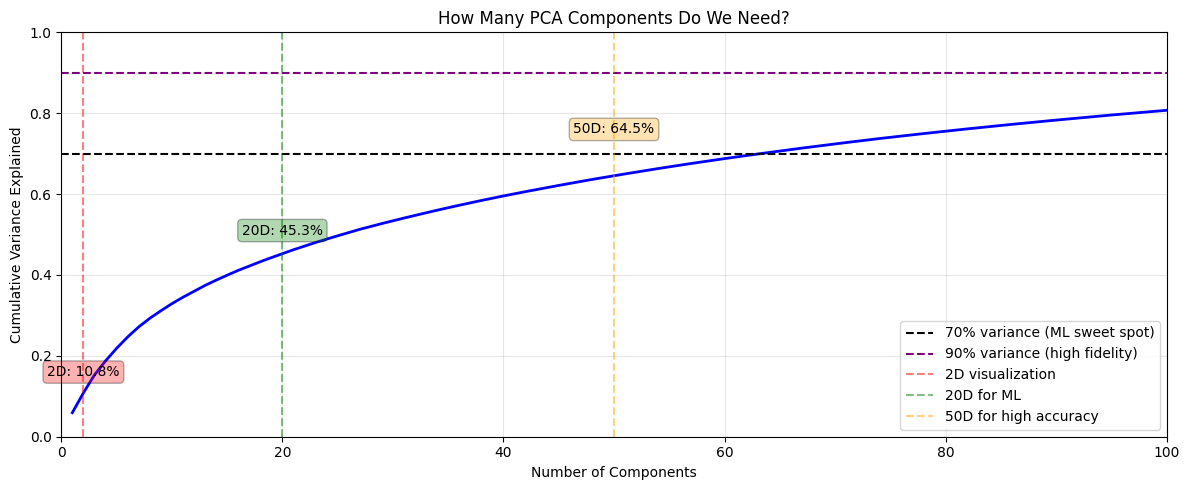


💡 Key Takeaway:
   • To capture 70% variance → Need ~64 components
   • To capture 90% variance → Need ~154 components
   • Current 2D visualization → Only captures 10.83%

   → This is why we use full 384D for clustering and ML!


In [53]:
# Visualize cumulative variance explained
pca_full = PCA(random_state=42)
pca_full.fit(embeddings_matrix)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(12, 5))

# Plot cumulative variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         linewidth=2, color='blue')

# Mark important thresholds
plt.axhline(y=0.70, color='black', linestyle='--', label='70% variance (ML sweet spot)')
plt.axhline(y=0.90, color='purple', linestyle='--', label='90% variance (high fidelity)')
plt.axvline(x=2, color='red', linestyle='--', alpha=0.5, label='2D visualization')
plt.axvline(x=20, color='green', linestyle='--', alpha=0.5, label='20D for ML')
plt.axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='50D for high accuracy')

# Annotations
plt.text(2, 0.15, f'2D: {cumulative_variance[1]:.1%}', ha='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
plt.text(20, 0.50, f'20D: {cumulative_variance[19]:.1%}', ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
plt.text(50, 0.75, f'50D: {cumulative_variance[49]:.1%}', ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('How Many PCA Components Do We Need?')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("\n💡 Key Takeaway:")
print(f"   • To capture 70% variance → Need ~{np.argmax(cumulative_variance >= 0.70) + 1} components")
print(f"   • To capture 90% variance → Need ~{np.argmax(cumulative_variance >= 0.90) + 1} components")
print(f"   • Current 2D visualization → Only captures {cumulative_variance[1]:.2%}")
print("\n   → This is why we use full 384D for clustering and ML!")